# Introduction
Habitify currently does not support an efficient visualization for tracking habits. You cannot see which habit you completed effectively i.e. in % in the past month. It aggregates this data for all habits or shows % per habit but doesn’t tell the days or color code the habit completion.

This project aims to show a color coded chart of what habits you are consistently forming, given the habit completion info from the past month.

In [1]:
import requests
from datetime import datetime, timedelta

JOURNAL_ENDPOINT = 'https://api.habitify.me/journal'
TIMEDELTA = 30

## Authentication
Gain access to my Habitify account.
Token copied from app.

In [2]:
AUTH_TOKEN = ""

## Compute Habit Completion Rate
Get the list of all habits. 
Check their completion status in the past 30 days.
Store counts in a list for future processing.

In [8]:
from logging import exception
from requests.models import HTTPError
from pytz import timezone
from urllib import parse
##################
# Data Structure Details #
# Dictionary 
# with key = <habit>, 
# value = <list of size 30 with each element True or False>
##################

# Query Habitify for raw_habits_data
def query_habitify(token : str) -> dict:
    # Function to query habitify for habits
    # token: authentication token
    # returns dict of <habits, list of completion every day>
    
    raw_habit_data = {}

    def get_habits_from_habitify(token: str, habit_date: datetime) -> dict:
        # Function wrapper to send GET requests and return santized output
        habits_and_status = {}

        api_headers = {'Authorization' : token}
        api_params = {'target_date': habit_date.isoformat()}
        
        try:
            api_response = requests.get(url=JOURNAL_ENDPOINT, headers=api_headers, params=api_params)
            
            # check api response
            if api_response.status_code!=200:
                print("Not received 200 OK")
                print(api_response.raise_for_status())
            
            api_response_json = api_response.json()
            if api_response_json['status'] != True:
                # api call success but failed to fetch data - refer to message
                raise exception(api_response_json['message'])

            for habit_info in api_response_json['data']:
                habit_name = habit_info['name']
                habit_status = habit_info['status']
                habits_and_status[habit_name] = habit_status

        except requests.exceptions.HTTPError as err:
            print("Unknown HTTP Error", err)
            return None

        except:
            print('Unknown Error')
            return None

        return habits_and_status


    # start from 30 days before current date
    current_date = datetime.now(tz=timezone('UTC')).replace(microsecond=0)
    habit_date = current_date - timedelta(days=TIMEDELTA)

    for i in range(0,TIMEDELTA):
        # get habits for current habit date
        # habitify_response = None if API failed
        # = dictionary of key=<habit>, val=<habit status>
        habitify_response: dict = get_habits_from_habitify(token, habit_date)
        if habitify_response is None:
            # api call failed for specific day
            pass
        else:
            # add result to raw_habit_data dict
            for habit, habit_status in habitify_response.items():
                if habit in raw_habit_data:
                    raw_habit_data[habit].append(True if habit_status=='completed' else False)
                else:
                    raw_habit_data[habit] = [True if habit_status=='completed' else False]

        # increment date
        habit_date = habit_date + timedelta(days=1)

    return raw_habit_data


In [9]:
last_months_habitify_data = query_habitify(AUTH_TOKEN)
print(last_months_habitify_data)

{'Drink Water': [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False], 'Meditate': [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False], 'To-do List': [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False], 'Read Books': [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False], 'Core Training': [False, False, False, False, False, False, False, False, False, False, False, Fa

# Visualize Habit Completion Rate
Now we have the dictionary of {habit: list of days where habit was recorded}. 

How to visualize: Pie chart with 30 sectors for each day. Color code green and aggregate for completed tasks. Red for failed. Gray for unrecorded.

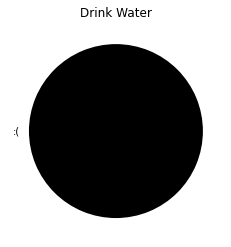

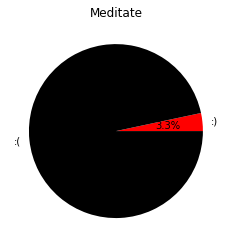

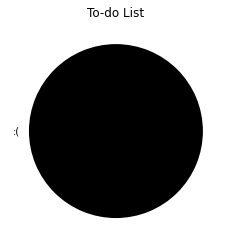

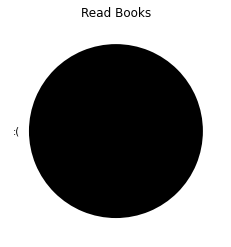

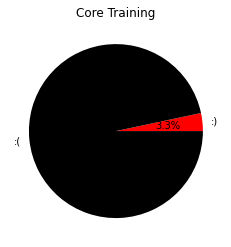

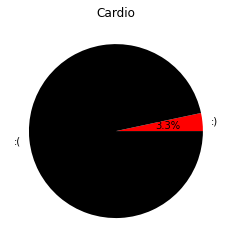

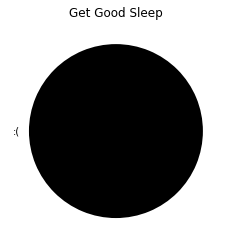

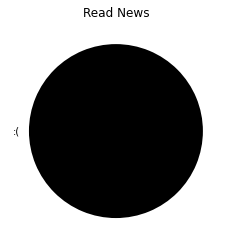

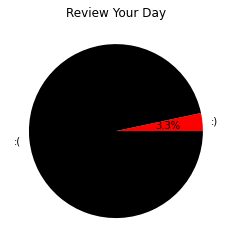

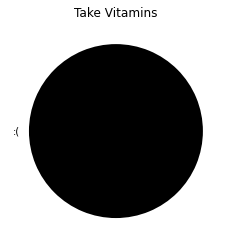

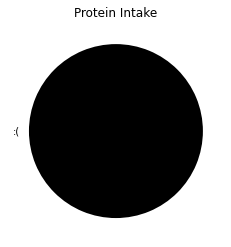

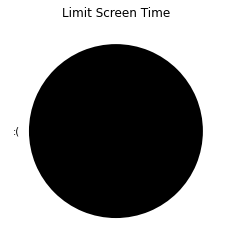

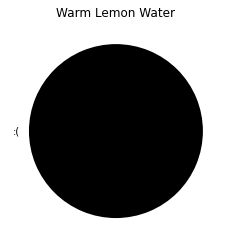

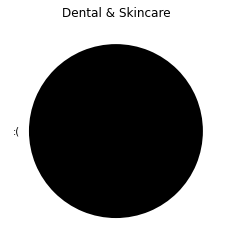

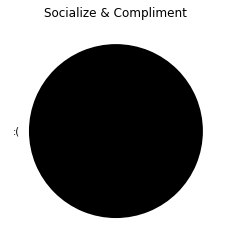

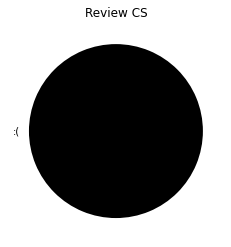

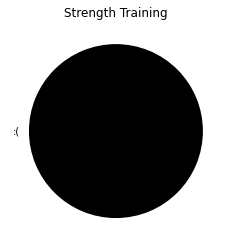

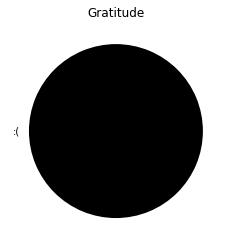

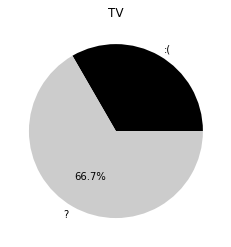

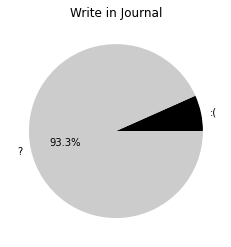

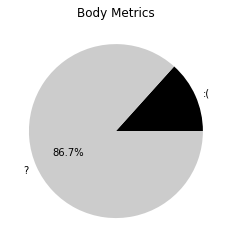

In [23]:
from matplotlib import pyplot as plt

# for each habit, count True and False values
for habit, raw_progress in last_months_habitify_data.items():
    count_true = raw_progress.count(True)
    count_false = raw_progress.count(False)
    count_unknown = TIMEDELTA - count_true - count_false


    def pie_chart_precision_generator(val):
        if val==0:
            return ''
        return '%1.1f%%' % val

    plt.title(loc='center', label=habit)
    plt.pie( x=[count_true, count_false, count_unknown], 
            labels = [':)' if count_true!=0 else '', ':(' if count_false!=0 else '', '?' if count_unknown!=0 else ''], 
            autopct=pie_chart_precision_generator,
            colors=['g' if (count_true/TIMEDELTA)>=0.8 else 'y' if (count_true/TIMEDELTA)>=0.3 else 'r', '0', '0.8'] )

    # show plot
    plt.show()